(-0.5, 639.5, 479.5, -0.5)

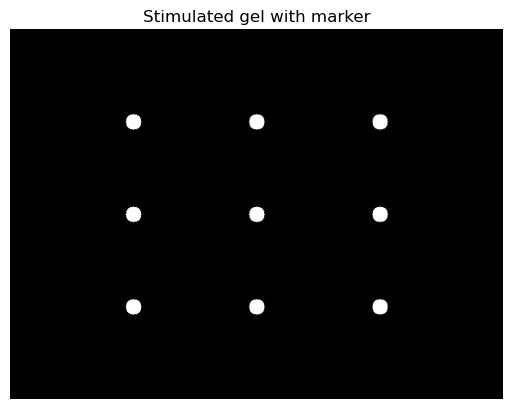

In [1]:
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

# Create a blank black image with 640x480 resolution
image = np.zeros((480, 640, 3), dtype=np.uint8)

# Define the radius of the circles
radius = 10  # Adjusting the radius for better visibility

# Define the color of the circles (BGR format, here it's white)
color = (255, 255, 255)

# Calculate spacing between circles
rows = 3
cols = 3
x_spacing = image.shape[1] // (cols + 1)
y_spacing = image.shape[0] // (rows + 1)

# Function to calculate the current timestamp
def get_timestamp():
    """ return unix timestamp """
    current_time =  datetime.now().timetuple()
    return time.mktime(current_time)


# Create a list to store marker information
markers_info = []

# Draw the circles on the image and calculate centroids
center_points = []
for i in range(1, rows + 1):
    for j in range(1, cols + 1):
        center = (x_spacing * j, y_spacing * i)
        center_points.append(center)
        cv2.circle(image, center, radius, color, thickness=-1)
        
        # Create a marker info dictionary
        marker_info = {
            'timestamp': get_timestamp(),
            'x': center[0],
            'y': center[1],
            'polarity': np.random.choice([0, 1])  # Randomly assign polarity 0 or 1
        }
        markers_info.append(marker_info)


plt.imshow(image, cmap="gray")
plt.title("Stimulated gel with marker")
plt.axis('off')

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [100/1000], Loss: 7.6188
Epoch [200/1000], Loss: 1.0098
Epoch [300/1000], Loss: 16.9736
Epoch [400/1000], Loss: 0.2791
Epoch [500/1000], Loss: 2.5656
Epoch [600/1000], Loss: 2.3980
Epoch [700/1000], Loss: 0.0396
Epoch [800/1000], Loss: 0.2922
Epoch [900/1000], Loss: 0.5721
Epoch [1000/1000], Loss: 1.2221


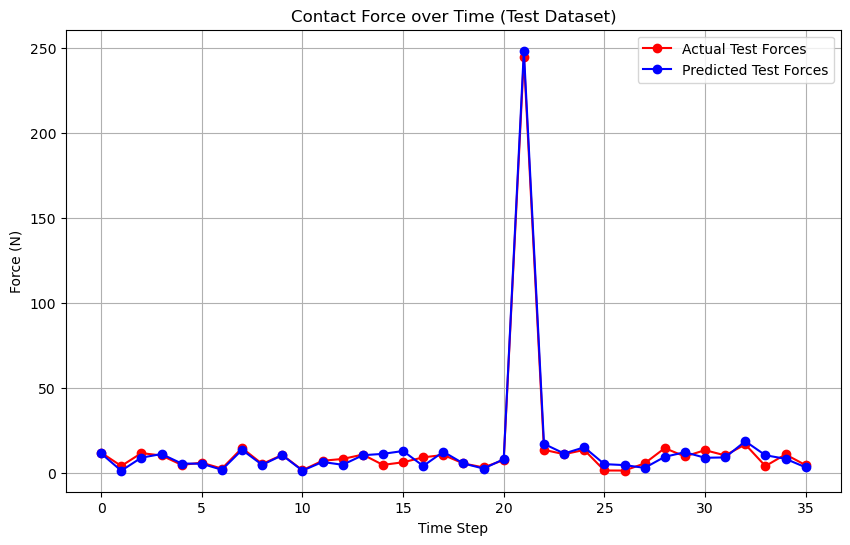

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm.auto import tqdm

# Function to create a 2D rotation matrix
def create_2d_rotation_matrix(angle_degrees):
    angle_radians = np.radians(angle_degrees)
    cos_angle = np.cos(angle_radians)
    sin_angle = np.sin(angle_radians)
    return np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])


# Define the objective function (mean squared error)
def objective_function(R, t, initial, observed):
    transformed = np.dot(initial, R.T) + t
    return np.mean(np.sum((transformed - observed)**2, axis=1))

# Prepare the dataset
num_time_steps = 20
noise_level = 5
mass = 1.0  # Mass of each marker in kilograms (kg)
time_interval = 1.0  # Time interval between t and t+1 in seconds (s)
initial_centroids = np.array(center_points)
true_rotation_angle = 0
true_rotation = create_2d_rotation_matrix(true_rotation_angle)
true_translation = np.array([15, 10])

observed_centroids = np.dot(initial_centroids, true_rotation.T) + true_translation

learning_rate = 0.001
num_iterations = 1000
R_est = np.eye(2)
t_est = np.zeros(2)

for i in range(num_iterations):
    transformed_centroids = np.dot(initial_centroids, R_est.T) + t_est
    error = transformed_centroids - observed_centroids
    grad_R = 2 * np.dot(error.T, initial_centroids)
    grad_t = 2 * np.sum(error, axis=0)
    R_est -= learning_rate * grad_R
    t_est -= learning_rate * grad_t
    U, _, Vt = np.linalg.svd(R_est)
    R_est = np.dot(U, Vt)

previous_centroids = transformed_centroids
all_features = []
all_forces = []

for t in range(num_time_steps):
    noise = np.random.normal(scale=noise_level, size=initial_centroids.shape)
    simulated_translation = true_translation * (t + 1) / num_time_steps + noise
    observed_centroids_t = np.dot(initial_centroids, true_rotation.T) + simulated_translation
    displacements = observed_centroids_t - previous_centroids
    velocities = displacements / time_interval
    accelerations = velocities / time_interval
    forces = mass * accelerations
    all_features.append(np.hstack((previous_centroids, observed_centroids_t)))
    all_forces.append(forces)
    previous_centroids = observed_centroids_t

features = np.vstack(all_features)
forces = np.vstack(all_forces)

# Convert to PyTorch tensors
features_tensor = torch.tensor(features, dtype=torch.float32)
forces_tensor = torch.tensor(forces, dtype=torch.float32)

# Create a dataset and data loader
dataset = TensorDataset(features_tensor, forces_tensor)
train_size = int(len(dataset) * 0.8)
test_size = int(len(dataset) * 0.2)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing sets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define the neural network
class ForcePredictor(nn.Module):
    def __init__(self):
        super(ForcePredictor, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = ForcePredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


model.eval()
all_test_forces = []
all_predicted_test_forces = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        all_test_forces.append(targets)
        all_predicted_test_forces.append(outputs)

all_test_forces = torch.cat(all_test_forces).numpy()
all_predicted_test_forces = torch.cat(all_predicted_test_forces).numpy()

# Calculate the mean forces for visualization
mean_test_forces = np.linalg.norm(all_test_forces, axis=1)
mean_predicted_test_forces = np.linalg.norm(all_predicted_test_forces, axis=1)

# Plot the forces against the time steps for the test dataset
plt.figure(figsize=(10, 6))
plt.plot(range(test_size), mean_test_forces, marker='o', linestyle='-', color='r', label='Actual Test Forces')
plt.plot(range(test_size), mean_predicted_test_forces, marker='o', linestyle='-', color='b', label='Predicted Test Forces')
plt.title('Contact Force over Time (Test Dataset)')
plt.xlabel('Time Step')
plt.ylabel('Force (N)')
plt.grid(True)
plt.legend()
plt.show()